# Step 1 : Segmentation of Dataset 1
## 1.1 import dataset 1 with mask
The dataset contains 4237 MRI images of brain tumors, each accompanied by a corresponding manual mask generated by experts to accurately delineate the tumor boundaries.

This dataset is used to train a segmentation model to detect and segment four different types of brain tumors:

Dataset Description:
### Images:
0 (No Tumor): 1595 images

1 (Glioma): 649 images

2 (Meningioma): 999 images

3 (Pituitary): 994 images
### Masks:
0 (No Tumor): 1595 masks

1 (Glioma): 650 masks

2 (Meningioma): 1000 masks

3 (Pituitary): 994 masks

In [1]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import zipfile
from collections import Counter

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

from tensorflow.keras.models import load_model
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
#dataset1 with  mask
!kaggle datasets download -d atikaakter11/brain-tumor-segmentation-dataset
#dataset2 with no mask
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# Unzip dataset
path_to_zip_file = "brain-tumor-segmentation-dataset.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brain-tumor-segmentation-dataset")

path_to_zip_file = "brain-tumor-mri-dataset.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brain-tumor-mri-dataset")

# Remove the zip files after extraction
os.remove("/kaggle/working/brain-tumor-mri-dataset.zip")
os.remove("/kaggle/working/brain-tumor-segmentation-dataset.zip")

Dataset URL: https://www.kaggle.com/datasets/atikaakter11/brain-tumor-segmentation-dataset
License(s): MIT
 84%|████████████████████████████████▋      | 89.0M/106M [00:01<00:00, 66.2MB/s]
100%|████████████████████████████████████████| 106M/106M [00:01<00:00, 72.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98%|███████████████████████████████████████▎| 146M/149M [00:01<00:00, 99.8MB/s]
100%|█████████████████████████████████████████| 149M/149M [00:01<00:00, 109MB/s]


In [3]:
def load_images_and_masks(data_path, classes, target_size):
    images, masks, labels = [], [], []

    for class_name in classes:

        image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))

        mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))

        for image_name in os.listdir(image_folder):

            if image_name.endswith(('.jpg', '.png')):

                image_path = os.path.join(image_folder, image_name)

                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)


                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)# Display mask in grayscale
                image = cv2.resize(image, target_size) / 255.0# resize：Convert lists to NumPy arrays and normalize pixel values to [0, 1]

                if os.path.exists(mask_path):

                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)# Display mask in grayscale
                    mask = cv2.resize(mask, target_size) / 255.0# resize：Convert lists to NumPy arrays and normalize pixel values to [0, 1]

                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))

    images = np.array(images).reshape(-1, *target_size, 1)
    masks = np.array(masks).reshape(-1, *target_size, 1)
    labels = np.array(labels)
    return images, masks, labels

In [4]:
#dataset 1
data_path ="/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"

# Classes  tumors
classes = ["0", "1", "2", "3"]

target_size = (128, 128)

images, masks, labels = load_images_and_masks(data_path, classes,target_size)

print(f"Number of images: {len(images)}, Number of masks: {len(masks)}, Number of labels: {len(labels)}")

Number of images: 4237, Number of masks: 4237, Number of labels: 4237


## 1.2 visualisation dataset

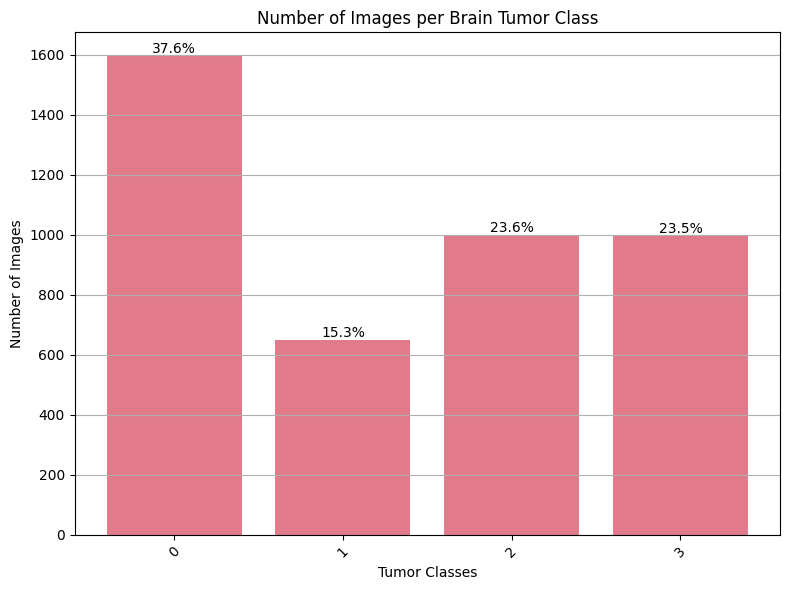

In [5]:
# Count the number of images per class
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))

# Calculate the total number of images and the percentages
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')

# Add percentages above the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Tumor Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Brain Tumor Class')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()


0 (No Tumor): 1595 images

1 (Glioma): 649 images

2 (Meningioma): 999 images

3 (Pituitary): 994 images

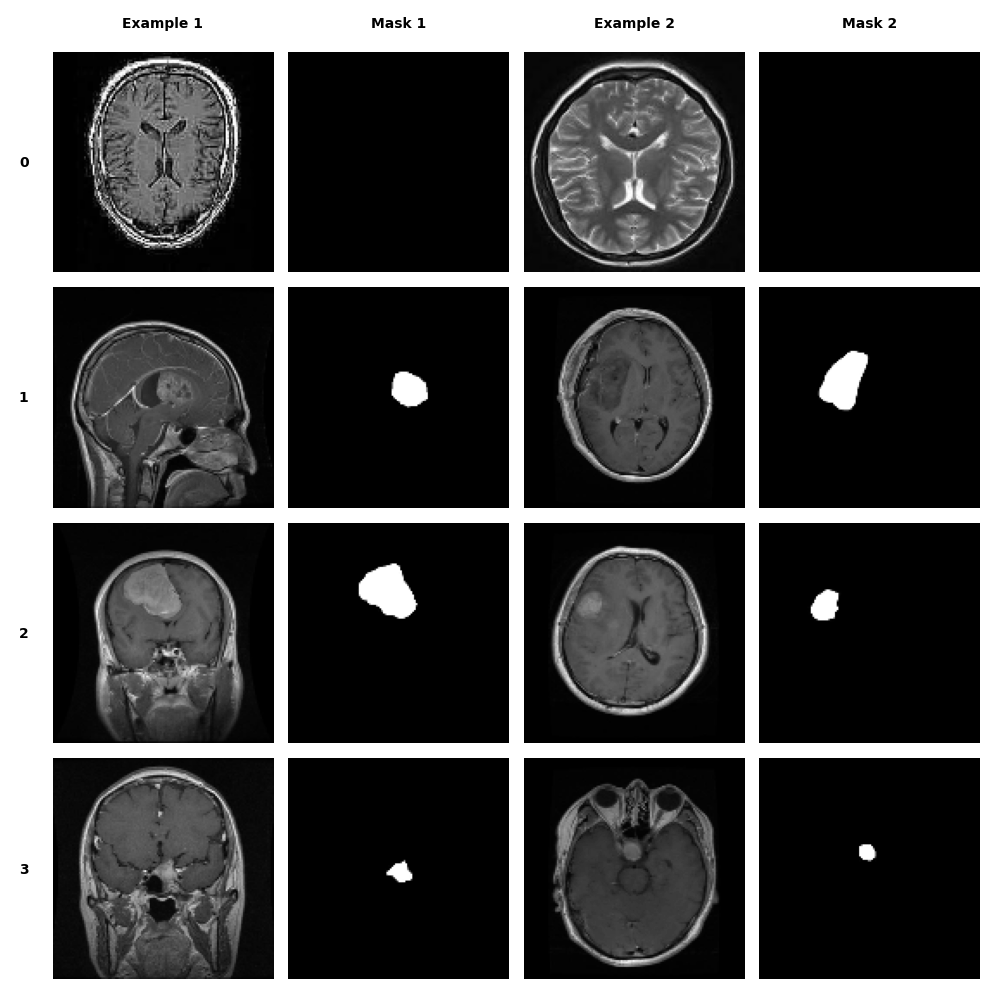

In [6]:
# Initialize the figure with a grid for 4 classes
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(10, 10),
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4 ,4], 'height_ratios': [0.5, 4, 4, 4, 4]})

# Column titles
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')  # Remove axes

axs[0, 1].text(0.5, 0.5, "Example 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')  # Remove axes

axs[0, 2].text(0.5, 0.5, "Mask 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')  # Remove axes

axs[0, 3].text(0.5, 0.5, "Example 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')  # Remove axes

axs[0, 4].text(0.5, 0.5, "Mask 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')  # Remove axes

for i, class_name in enumerate(classes):
    # Find an image and mask index for each class
    class_index = classes.index(class_name)

    # Get an example image and mask for each class
    example_index1 = np.where(labels == class_index)[0][0]  # Take the first example of each class
    example_index2 = np.where(labels == class_index)[0][2]  # Take the second example
    image1 = images[example_index1]
    mask1 = masks[example_index1]

    image2 = images[example_index2]
    mask2 = masks[example_index2]

    # Display the image
    axs[i + 1, 1].imshow(image1, cmap='gray')
    axs[i + 1, 1].axis('off')  # Remove axes

    # Display the mask
    axs[i + 1, 2].imshow(mask1, cmap='gray')
    axs[i + 1, 2].axis('off')  # Remove axes

    # Display the image
    axs[i + 1, 3].imshow(image2, cmap='gray')
    axs[i + 1, 3].axis('off')  # Remove axes

    # Display the mask
    axs[i + 1, 4].imshow(mask2, cmap='gray')
    axs[i + 1, 4].axis('off')  # Remove axes

    # Center the text in the class column
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')  # Remove axes

plt.tight_layout()
plt.show()


## 1.3 Data Preparation

In [7]:
# Split the data into training (75%) and validation (25%) sets
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

# Display the dimensions of the datasets
print(f"Training set - Images: {images_train.shape}, Masks: {masks_train.shape}, Labels: {labels_train.shape}")
print(f"Validation set - Images: {images_val.shape}, Masks: {masks_val.shape}, Labels: {labels_val.shape}")


Training set - Images: (2965, 128, 128, 1), Masks: (2965, 128, 128, 1), Labels: (2965,)
Validation set - Images: (1272, 128, 128, 1), Masks: (1272, 128, 128, 1), Labels: (1272,)


In [8]:
# Function to create a generator that applies the same augmentation to images and masks
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generators for images and masks
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    while True:
        # Generate a batch of images and masks
        img_batch = next(image_generator)  # Use `next(image_generator)`
        mask_batch = next(mask_generator)  # Use `next(mask_generator)`

        yield img_batch, mask_batch


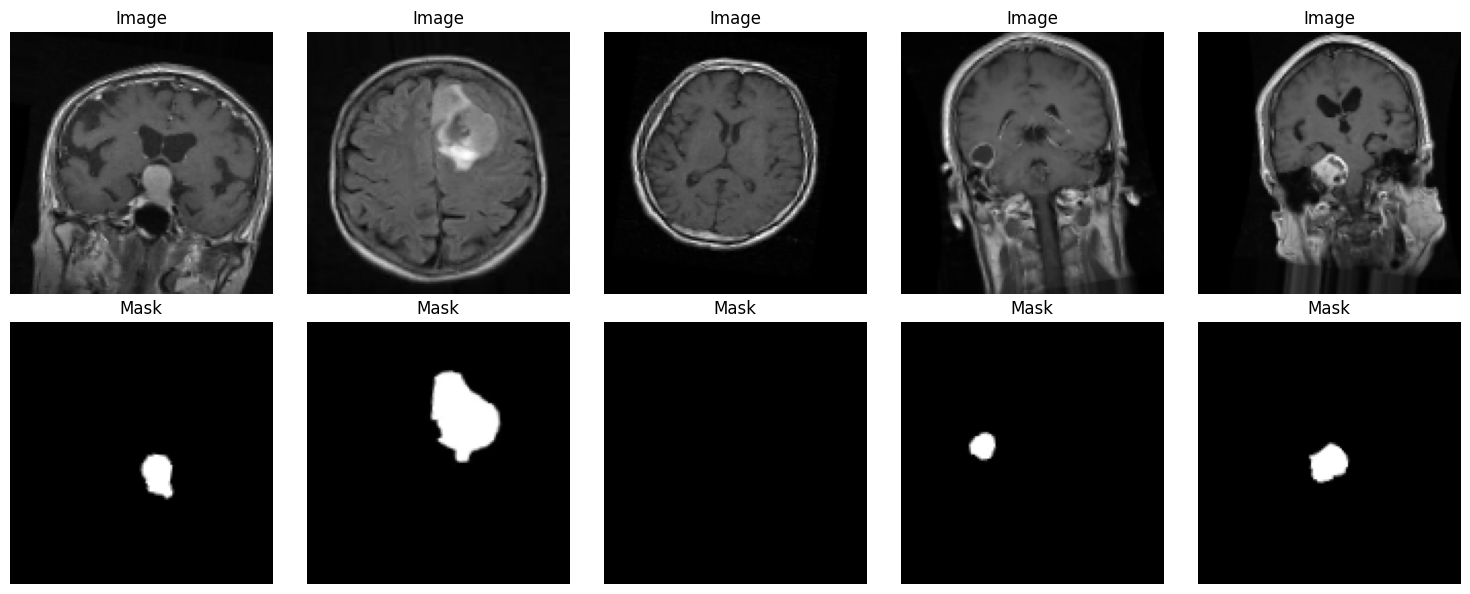

In [9]:
# Function to display images and their corresponding masks
def plot_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Display the image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')  # Adjust the shape if necessary
        plt.axis('off')
        plt.title('Image')

        # Display the corresponding mask
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')  # Adjust the shape if necessary
        plt.axis('off')
        plt.title('Mask')

    plt.tight_layout()
    plt.show()

# Test the augmentation generator by taking a few images
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))

# Display the images and masks
plot_images(images_batch, masks_batch, num_images=5)


## 1.3 train model : U-NET

The metrics Dice Coefficient (DICE), Dice Loss, and Intersection over Union (IoU) are commonly used to evaluate the performance of image segmentation models, especially in medical segmentation tasks. :

<div style='text-align: center'>
    <img src="https://www.researchgate.net/publication/354660434/figure/fig4/AS:1069085387395072@1631901227555/The-visualization-of-Dice-and-IoU-The-left-image-presents-the-Dice-coefficient-the.png" width="250">
    </div>





In [10]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)


In [11]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contraction Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer with a single channel for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


# Define the input shape (height, width, channels)
input_shape = (128, 128, 1)
model = unet_model(input_shape)
model.summary()

# Compile the model
#model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 512)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

the dataset is imbalanced (e.g., most pixels are background), accuracy might give a misleadingly high value. For example, if 90% of the pixels are background, a model that always predicts background will have 90% accuracy but fail on the important foreground regions.

In [12]:
# Define the callbacks
model_checkpoint = ModelCheckpoint('best_unetmodel.keras',  # File name to save the best model
                                   monitor='val_dice_coefficient',  # Monitor the validation Dice Coefficient value
                                   save_best_only=True,  # Save only the best model
                                   mode='max',  # Look for the maximum value
                                   verbose=1  # Display a message when saving
                                  )

early_stopping = EarlyStopping(monitor='val_dice_coefficient',
                               patience=10,  # Stop after 10 epochs without improvement
                               mode='max',  # Look for the maximum value
                               verbose=1  # Display a message when stopping
                              )





###  **handle class imbalances** 

In [13]:
def train_generator_with_weights(images, masks, batch_size, class_weights, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generators for images and masks
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    while True:
        # Generate a batch of images and masks
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)

        # Generate pixel-level weights for the batch
        pixel_weights_batch = np.zeros_like(mask_batch, dtype=np.float32)
        for cls, weight in class_weights.items():
            pixel_weights_batch[mask_batch == cls] = weight

        # Yield images, masks, and weights
        yield img_batch, mask_batch, pixel_weights_batch


In [15]:
# Calculate unique classes 
unique_classes = np.unique(masks_train)


class_counts = np.array([np.sum(masks_train == cls) for cls in unique_classes])

# Calculate class weights
class_weights = class_counts / np.sum(class_counts)


class_weights_dict = {int(cls): weight for cls, weight in zip(unique_classes, class_weights)}

batch_size=32
train_gen = train_generator_with_weights(images_train, masks_train, batch_size, class_weights_dict)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, iou]
)



In [16]:
# Train the model with the generator
history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // 32,
    epochs=100,
    validation_data=(images_val, masks_val),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9791 - dice_coefficient: 0.0179 - iou: 0.0091 - loss: 4.2320e-04
Epoch 1: val_dice_coefficient improved from -inf to 0.01263, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 888ms/step - accuracy: 0.9792 - dice_coefficient: 0.0179 - iou: 0.0090 - loss: 4.2261e-04 - val_accuracy: 0.9874 - val_dice_coefficient: 0.0126 - val_iou: 0.0064 - val_loss: 0.2186
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9851 - dice_coefficient: 0.0225 - iou: 0.0115 - loss: 1.9961e-04
Epoch 2: val_dice_coefficient improved from 0.01263 to 0.04792, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 522ms/step - accuracy: 0.9851 - dice_coefficient: 0.0227 - iou: 0.0115 - loss: 1.9932e-04 - val_accuracy: 0.9874 - val_dice_coefficient: 0.0479 - val_iou: 0.0246 - val_loss: 0.0987
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9858 - dice_coefficient: 0.0470 - iou: 0.0241

## 1.4 Evaluate Model

In [ ]:
# Evaluate the model on the training set
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Dice Coefficient: {train_dice_coef:.4f}')
print(f'Training IoU Coefficient: {train_iou_coef:.4f}')


In [18]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Dice Coefficient: {val_dice_coef:.4f}')
print(f'Validation IoU Coefficient: {val_iou_coef:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9932 - dice_coefficient: 0.7975 - iou: 0.6644 - loss: 0.0111
Validation Loss: 0.0121
Validation Accuracy: 0.9929
Validation Dice Coefficient: 0.7864
Validation IoU Coefficient: 0.6495


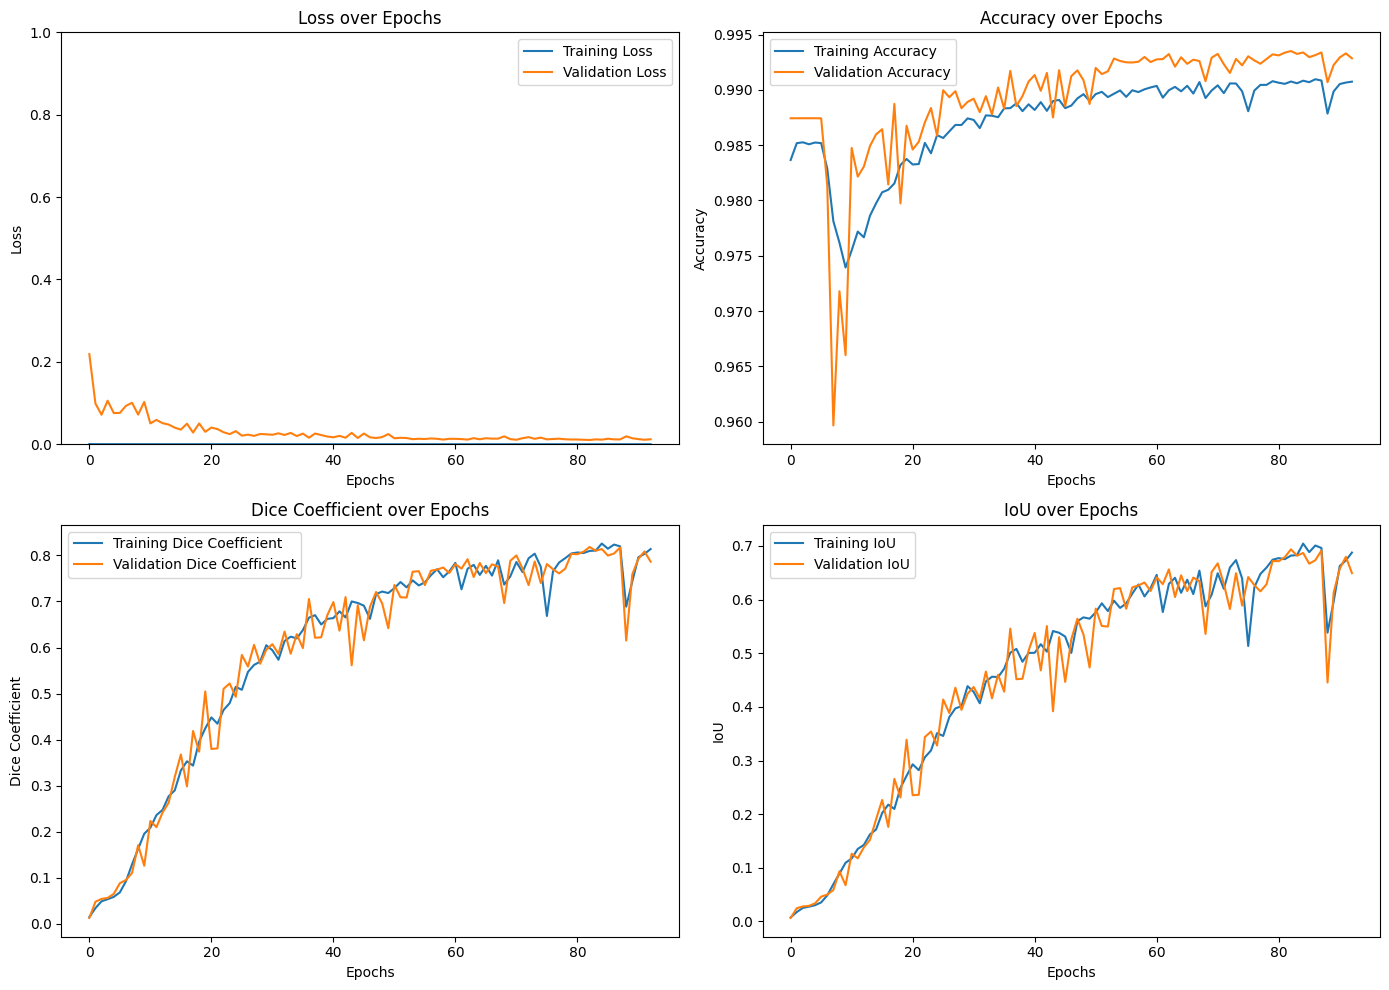

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss curve
axs[0, 0].plot(history.history['loss'], label='Training Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Loss over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()

# Plot Accuracy curve
axs[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('Accuracy over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].legend()

# Plot Dice Coefficient curve
axs[1, 0].plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
axs[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
axs[1, 0].set_title('Dice Coefficient over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Dice Coefficient')
axs[1, 0].legend()

# Plot IoU curve
axs[1, 1].plot(history.history['iou'], label='Training IoU')
axs[1, 1].plot(history.history['val_iou'], label='Validation IoU')
axs[1, 1].set_title('IoU over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].legend()

# Adjust space between subplots
plt.tight_layout()
plt.show()  

In [20]:
# Predictions on a validation set
print(len(images_val))
predictions = model.predict(images_val)  
predictions = (predictions > 0.5).astype(np.uint8)  # Binarize the predictions


1272
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


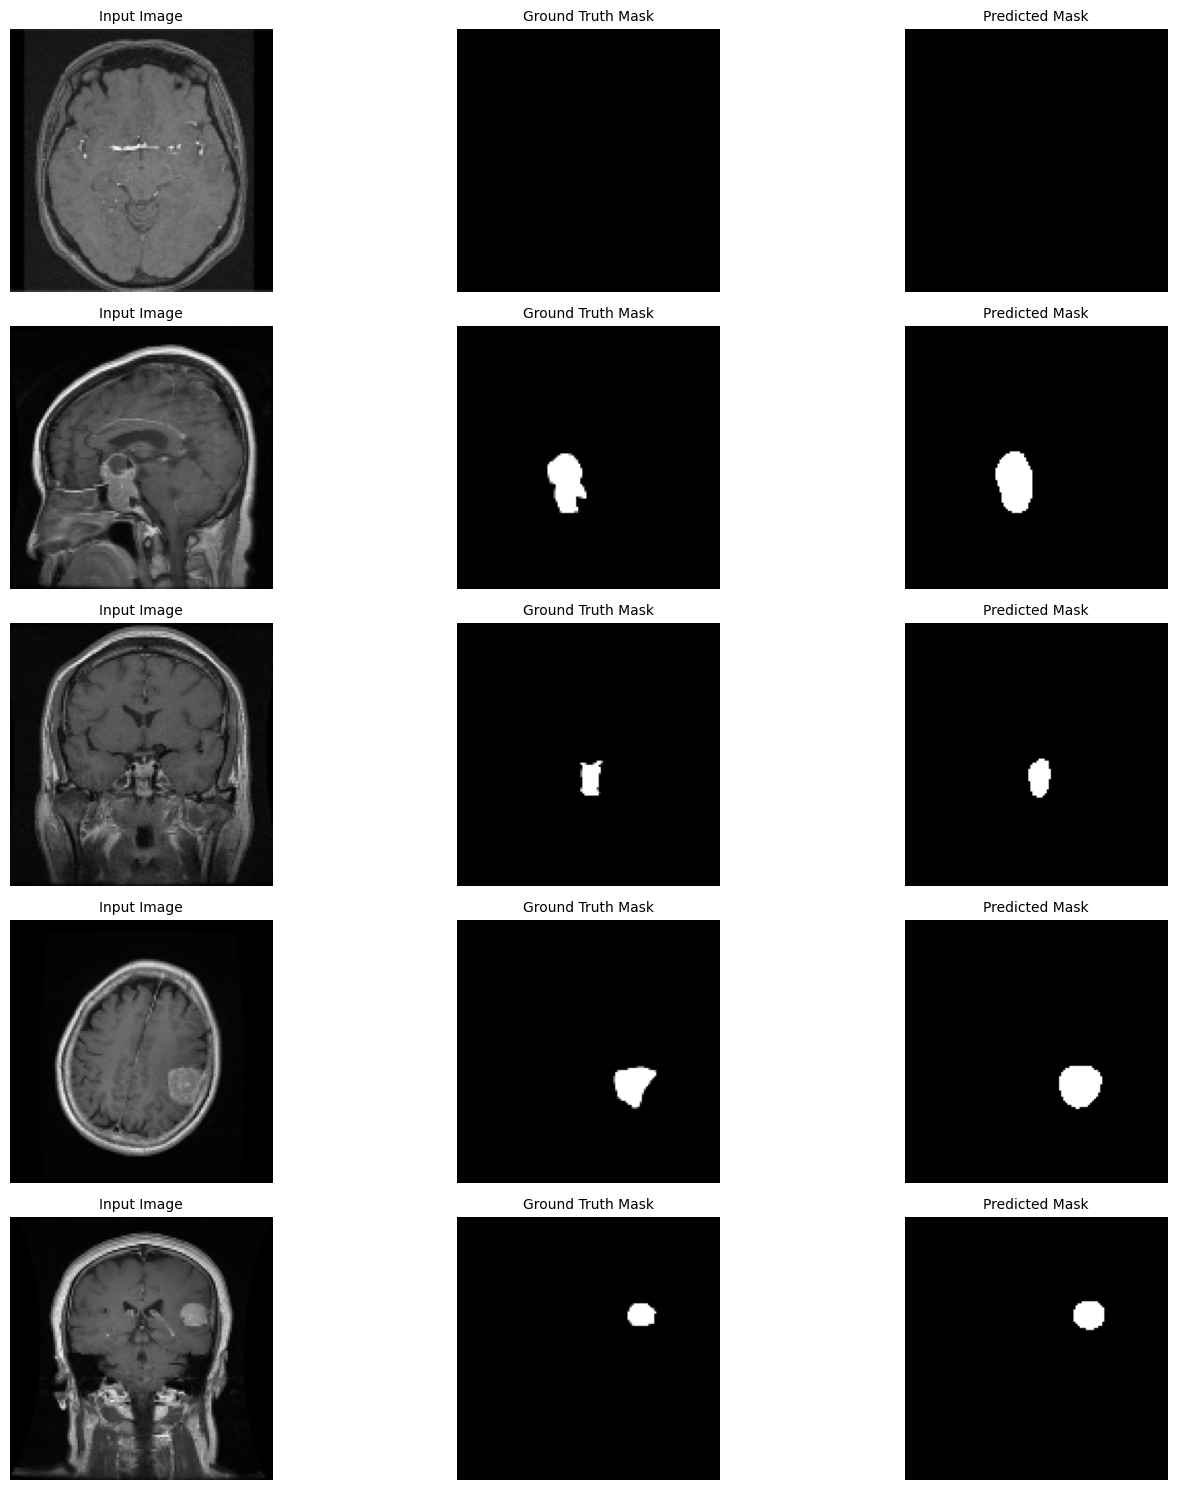

In [21]:
# Visualize some results
n = 5  # Number of examples to display
plt.figure(figsize=(15, 15))

for i in range(n):
    # Input image
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(images_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Input Image', fontsize=10)
    plt.axis('off')

    # Ground truth mask
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(masks_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Ground Truth Mask', fontsize=10)
    plt.axis('off')

    # Predicted mask
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(predictions[i+1].reshape(128, 128), cmap='gray')
    plt.title('Predicted Mask', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


## 1.5 predict mask for dataset 2 _sample

These predictions were made on another dataset for brain tumor classification "/content/brain-tumor-mri-dataset" to evaluate the robustness of the U-Net segmentation model, allowing the analysis of MRI images from a different context.

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


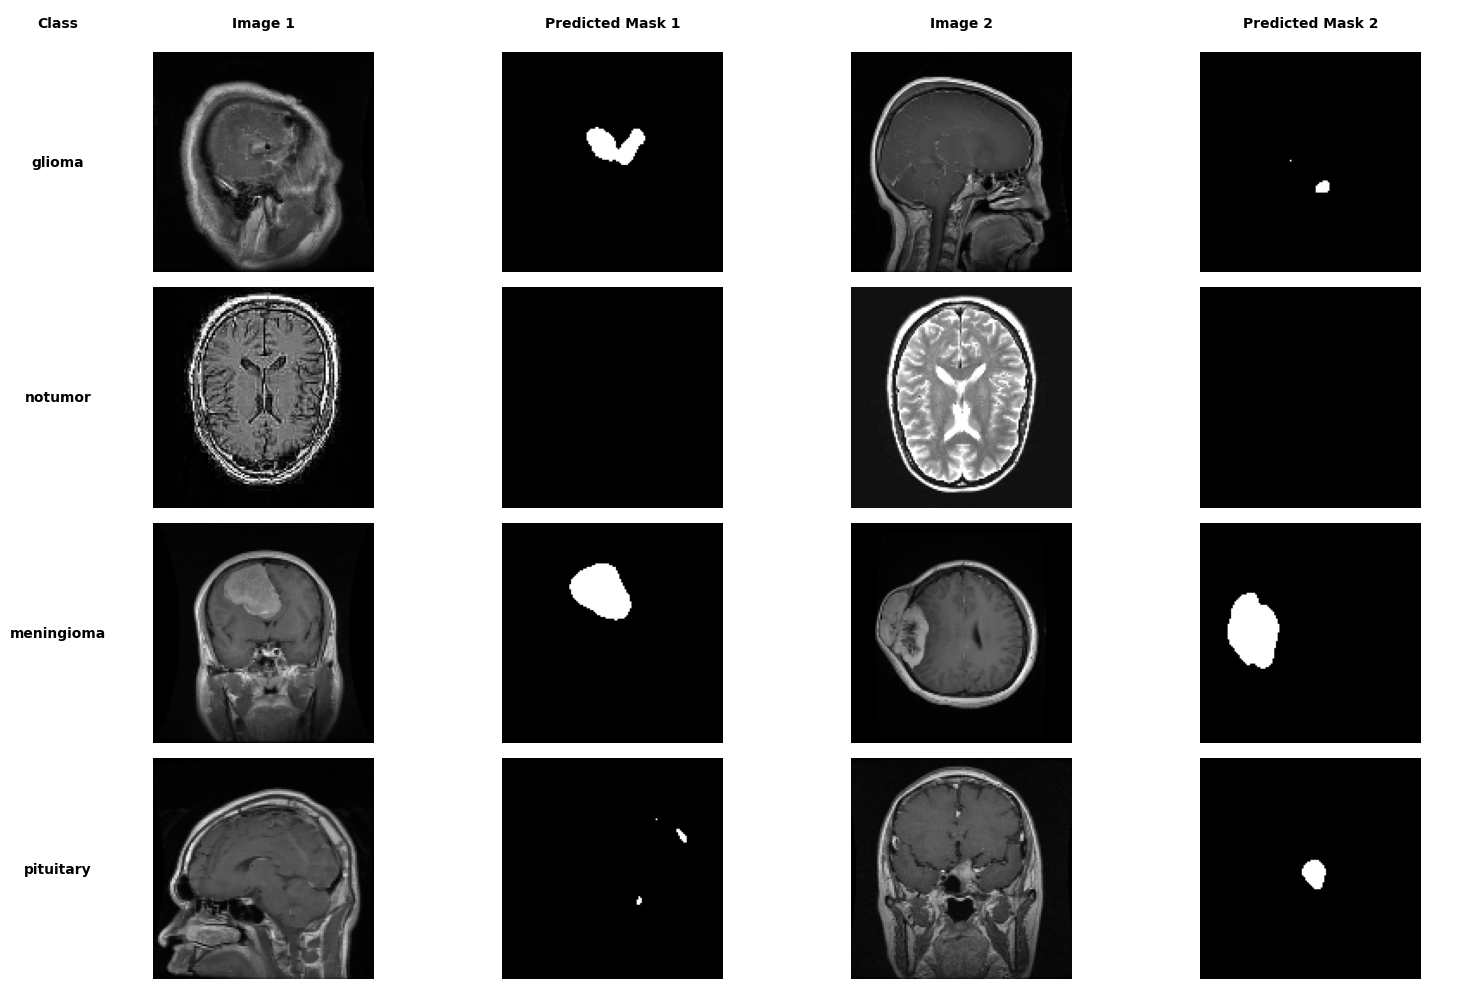

In [22]:
# Path to the test dataset
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
classes = ["glioma", "notumor", "meningioma", "pituitary"]
# Load two images from each class for testing
test_images = []
test_labels = []

for class_name in classes:
    class_folder = os.path.join(test_dir, class_name)

    # Get the names of the test images
    image_names = os.listdir(class_folder)

    # Ensure there are at least 2 images
    if len(image_names) >= 2:
        for image_name in image_names[:2]:  # Take the first two images from each class
            image_path = os.path.join(class_folder, image_name)

            # Load and preprocess the image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, target_size)
            image = image / 255.0
            image = np.expand_dims(image, axis=-1)  # Add the channel dimension

            test_images.append(image)
            test_labels.append(class_name)

# Convert to NumPy array
test_images = np.array(test_images)

# Make predictions on these new images
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(np.uint8)

# Initialize the figure with a grid for each class
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(15, 10),
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})

# Column titles
titles = ["Class", "Image 1", "Predicted Mask 1", "Image 2", "Predicted Mask 2"]
for j in range(5):
    axs[0, j].text(0.5, 0.5, titles[j], fontsize=10, ha='center', va='center', fontweight='bold')
    axs[0, j].axis('off')

# Display the images and their predictions
for i, class_name in enumerate(classes):
    class_indices = [j for j, label in enumerate(test_labels) if label == class_name]

    if len(class_indices) >= 2:  # Check if there are at least 2 indices for the class
        example_index1 = class_indices[0]
        example_index2 = class_indices[1]

        # Display the class name
        axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
        axs[i + 1, 0].axis('off')  # Remove the axes

        # Display the first image
        axs[i + 1, 1].imshow(test_images[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 1].axis('off')  # Remove the axes

        # Display the predicted mask for the first image
        axs[i + 1, 2].imshow(test_predictions[example_index1], cmap='gray')
        axs[i + 1, 2].axis('off')  # Remove the axes

        # Display the second image
        axs[i + 1, 3].imshow(test_images[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 3].axis('off')  # Remove the axes

        # Display the predicted mask for the second image
        axs[i + 1, 4].imshow(test_predictions[example_index2], cmap='gray')
        axs[i + 1, 4].axis('off')  # Remove the axes

plt.tight_layout()
plt.show()


# Step 2: Classfication using dataset 2

## 2.1 import dataset 2 with no mask
### Images(5378):

Training Set Class Distribution:
glioma: 1321
notumor: 1595
meningioma: 1339
pituitary: 1457

Testing Set Class Distribution:
glioma: 300
notumor: 405
meningioma: 306
pituitary: 300

In [23]:
def load_images_and_labels(data_path, classes, target_size):
    images, labels = [], []

    for class_name in classes:

        # Image and label directories
        image_folder = os.path.join(data_path, class_name)

        for image_name in os.listdir(image_folder):
            if image_name.endswith(('.jpg', '.png')):  # Check if the image is of the correct format
                image_path = os.path.join(image_folder, image_name)

                # Load the image in color (RGB)
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, target_size) / 255.0  # Normalize pixel values to [0, 1]

                images.append(image)
                labels.append(classes.index(class_name))  # Use the class index as the label

    # Convert lists to NumPy arrays
    images = np.array(images)  # Shape will be (num_images, target_height, target_width, 3)
    labels = np.array(labels)

    return images, labels


In [24]:
#train data
data_path_train ="/kaggle/input/brain-tumor-mri-dataset/Training"
# Classes des tumors
#test data
data_path_test ="/kaggle/input/brain-tumor-mri-dataset/Testing"
classes = ["glioma", "notumor", "meningioma", "pituitary"]


target_size = (128, 128)

images_train,labels_train= load_images_and_labels(data_path_train, classes,target_size)
images_test,labels_test= load_images_and_labels(data_path_test, classes,target_size)




print(f"Number of trian_images: {len(images_train)}, Number of train_labels: {len(labels_train)}")
print(f"Number of test_images: {len(images_test)}, Number of test_labels: {len(labels_test)}")
print(f"total images:{len(images_train)+len(images_test)}")


Number of trian_images: 5712, Number of train_labels: 5712
Number of test_images: 1311, Number of test_labels: 1311
total images:7023


In [25]:


# Count occurrences of each class in the train and test labels
unique_train, counts_train = np.unique(labels_train, return_counts=True)
unique_test, counts_test = np.unique(labels_test, return_counts=True)

# Print the number of images for each class in both training and testing sets
print("Training Set Class Distribution:")
for class_name, count in zip(unique_train, counts_train):
    print(f"{classes[class_name]}: {count}")

print("\nTesting Set Class Distribution:")
for class_name, count in zip(unique_test, counts_test):
    print(f"{classes[class_name]}: {count}")


Training Set Class Distribution:
glioma: 1321
notumor: 1595
meningioma: 1339
pituitary: 1457

Testing Set Class Distribution:
glioma: 300
notumor: 405
meningioma: 306
pituitary: 300


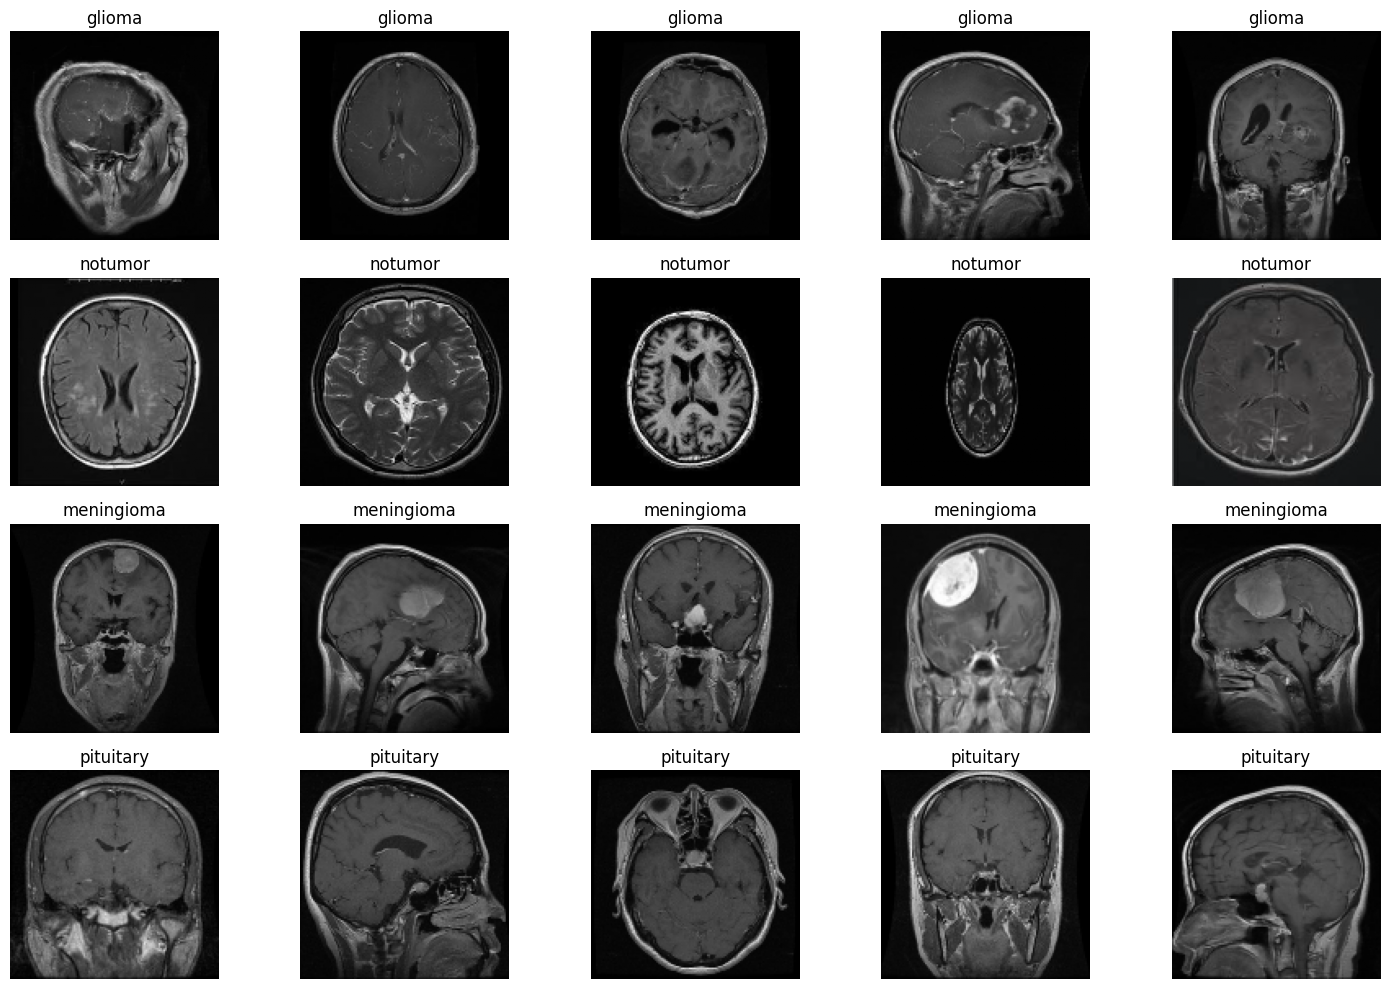

In [26]:
# Visualize a few random samples of images
class_names = ["glioma", "notumor", "meningioma", "pituitary"]
num_samples = 5


fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 10))

for class_idx, class_name in enumerate(class_names):

    class_images = [image for image, label in zip(images_train, labels_train) if label == class_idx]


    selected_indices = np.random.choice(len(class_images), num_samples, replace=False)

    for i, idx in enumerate(selected_indices):
        image = class_images[idx]

        axes[class_idx, i].imshow(image, cmap='gray')
        axes[class_idx, i].set_title(f"{class_name}")
        axes[class_idx, i].axis('off')

plt.tight_layout()
plt.show()


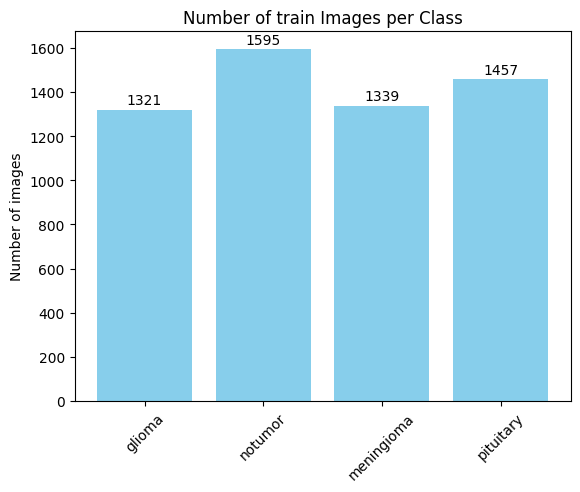

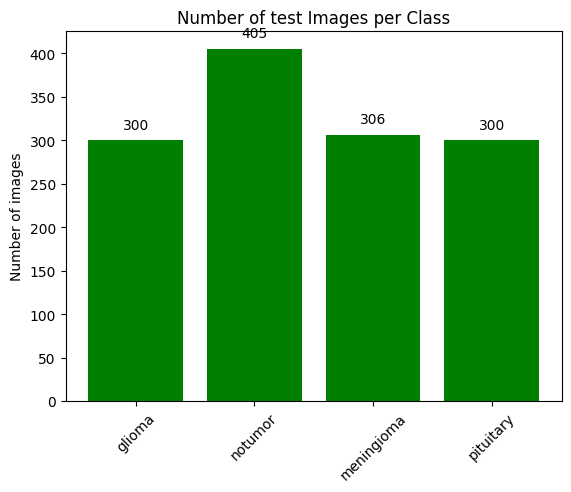

In [27]:
#plot train data


class_names = ['glioma','notumor',  'meningioma', 'pituitary']
class_counts = Counter(labels_train)
mapped_classes = [class_names[int(c)] for c in class_counts.keys()]


counts = list(class_counts.values())

plt.bar(mapped_classes, counts, color='skyblue')
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

#plt.xticks(classes)

plt.xticks(rotation=45)
plt.ylabel('Number of images')
plt.title('Number of train Images per Class')
plt.show()

#plot test data


class_counts = Counter(labels_test)
mapped_classes = [class_names[int(c)] for c in class_counts.keys()]


counts = list(class_counts.values())

plt.bar(mapped_classes, counts, color='green')
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

#plt.xticks(classes)

plt.xticks(rotation=45)
plt.ylabel('Number of images')
plt.title('Number of test Images per Class')
plt.show()

## 2.2 Data Augmentation and Data Loading# 

In [28]:
 #Split the dataset1 into train and validation sets
train_image, val_image = train_test_split(images_train, test_size=0.2, random_state=42)
train_label, val_label = train_test_split(labels_train, test_size=0.2, random_state=42)




print("Train image shape:", train_image.shape)
print("Train label shape:", train_label.shape)


print("Validation image shape:", val_image.shape)
print("Validation label shape:", val_label.shape)



Train image shape: (4569, 128, 128, 3)
Train label shape: (4569,)
Validation image shape: (1143, 128, 128, 3)
Validation label shape: (1143,)


In [29]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalization
    rotation_range=40,            # Randomly rotate images
    width_shift_range=0.2,        # Random horizontal shift
    height_shift_range=0.2,       # Random vertical shift
    shear_range=0.2,              # Random shear transformation
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flip
    fill_mode='nearest'           # Fill mode
)

# Validation data augmentation (only normalization, no other augmentations)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate training data
train_generator = train_datagen.flow(train_image, train_label, batch_size=32)
val_generator = val_datagen.flow(val_image, val_label, batch_size=32)

# Test the output of the generator
for x_batch, y_batch in train_generator:
    print(x_batch.shape, y_batch.shape)  # Output the shape of images and labels in the batch
    break


(32, 128, 128, 3) (32,)


## 2.3 Load Pre-trained Reset50 Model

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

In [31]:
# Load the pre-trained ResNet50 model, excluding the top fully connected layers (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Define the input layer
inputs = layers.Input(shape=(128, 128, 3))

# Pass the input to the ResNet50 model
x = base_model(inputs)

# Add a global average pooling layer
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = layers.Dense(1024, activation='relu')(x)

# Add a Dropout layer
x = layers.Dropout(0.5)(x)

# Add the output layer
outputs = layers.Dense(4, activation='softmax')(x)

# Define the model
model_ResNet50 = models.Model(inputs, outputs)

# Freeze the convolutional layers of ResNet50 and only train the custom fully connected layers
for layer in base_model.layers:
    layer.trainable = False

# Display the model architecture
model_ResNet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 2.4 Train model

In [32]:

model_ResNet50.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])


In [33]:

history = model_ResNet50.fit(train_image, train_label, epochs=100, batch_size=32, validation_data=(val_image, val_label))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.3269 - loss: 1.3986 - val_accuracy: 0.5389 - val_loss: 1.1578
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4447 - loss: 1.2129 - val_accuracy: 0.5879 - val_loss: 1.0753
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4795 - loss: 1.1581 - val_accuracy: 0.6352 - val_loss: 1.0208
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5379 - loss: 1.0647 - val_accuracy: 0.6159 - val_loss: 0.9892
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5817 - loss: 1.0366 - val_accuracy: 0.6518 - val_loss: 0.9418
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5976 - loss: 1.0069 - val_accuracy: 0.6509 - val_loss: 0.9139
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6157 - loss: 0.9624 - val_accuracy: 0.6719 - val_loss: 0.8855
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6324 - loss: 0.9198 

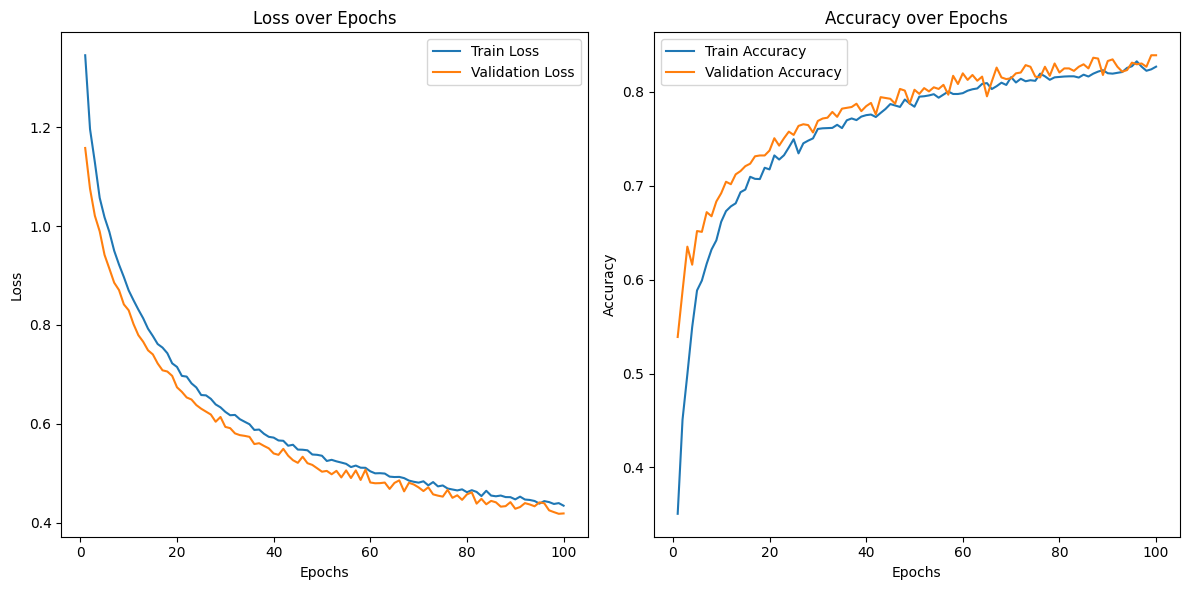

In [34]:
epochs = range(1, len(train_loss) + 1) 
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


## 2.5 Evaluate model

In [35]:

#evaluate model by test data
test_loss, test_accuracy = model_ResNet50.evaluate(images_test,labels_test, 32)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7360 - loss: 0.5886
Test Loss: 0.5317367911338806, Test Accuracy: 0.7757437229156494


In [36]:
# save model
model_ResNet50.save('resnet50_model.h5')

# load model
# model = tf.keras.models.load_model('resnet50_model.h5')


In [37]:
# Use the trained model to make predictions
y_pred = model_ResNet50.predict(images_test)

# Get the predicted class labels (select the class with the highest probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display the predicted classes and the true labels
print(f'Predicted classes: {y_pred_classes[:10]}')
print(f'True classes: {labels_test[:10]}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step
Predicted classes: [0 2 0 2 0 0 0 0 2 2]
True classes: [0 0 0 0 0 0 0 0 0 0]


###   balance test set

In [38]:
from sklearn.metrics import accuracy_score


# Ensure y_pred is a 1D array of class labels (if it's a probability distribution)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure labels_test is a 1D array of labels (if it's one-hot encoded)
if labels_test.ndim > 1:
    labels_test = np.argmax(labels_test, axis=1)

# Calculate accuracy for each class
unique_classes = np.unique(labels_test)
class_accuracies = []

for cls in unique_classes:
    # Get all true labels and predicted labels for class cls
    true_class = (labels_test == cls)
    pred_class = (y_pred_classes == cls)

    # Calculate the accuracy for this class
    accuracy = np.sum(true_class & pred_class) / np.sum(true_class)  # Accuracy for this class
    class_accuracies.append(accuracy)

# Calculate the sample weights for each class
class_counts = np.array([np.sum(labels_test == cls) for cls in unique_classes])
class_weights = class_counts / np.sum(class_counts)

# Calculate weighted accuracy
weighted_accuracy = np.sum(np.array(class_accuracies) * class_weights)

print(f"Weighted Accuracy: {weighted_accuracy}")


Weighted Accuracy: 0.7757437070938216


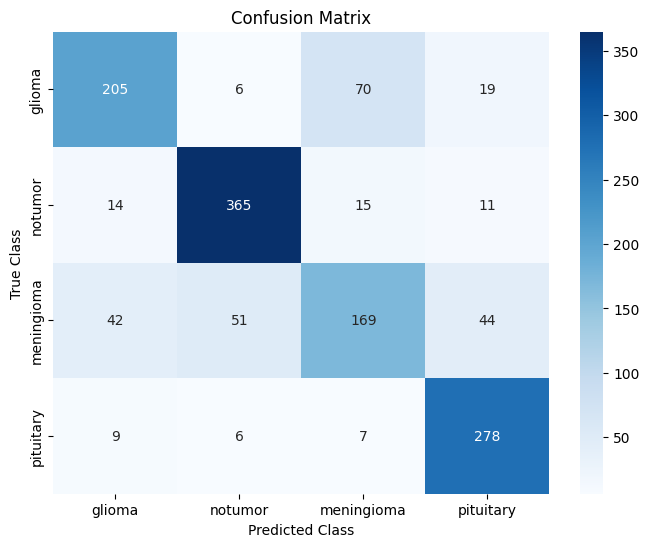

In [39]:
# Compute the confusion matrix
cm = confusion_matrix(labels_test, y_pred_classes)



# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Step 3 classfication using generated mask 

##  3.1 generate mask 

In [40]:
def save_masks_by_class(masks, labels, classes, output_dir):
    """
    Save masks to class-specific folders and print the count of each class.

    Args:
        masks (np.ndarray): Array of predicted masks.
        labels (np.ndarray): Array of numeric labels.
        classes (list): List of class names.
        output_dir (str): Directory to save the masks.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a folder for each class and initialize a counter for each class
    class_counts = {class_name: 0 for class_name in classes}
    for class_name in classes:
        class_folder = os.path.join(output_dir, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

    # Save masks and update class counts
    for i, (mask, label) in enumerate(zip(masks, labels)):
        class_name = classes[label]
        class_folder = os.path.join(output_dir, class_name)
        file_path = os.path.join(class_folder, f"mask_{i + 1}.png")
        cv2.imwrite(file_path, (mask * 255).astype(np.uint8))  # Save mask as PNG image
        class_counts[class_name] += 1

    # Print the count of masks for each class
    for class_name, count in class_counts.items():
        print(f"Class '{class_name}': {count} masks")

    print(f"Masks have been saved to {output_dir}.")


In [41]:
def generate_mask(test_dir, classes, target_size,model_path, threshold=0.5):
    """
    Load image data and generate predicted masks along with corresponding labels.

    Args:
        test_dir (str): Path to the test dataset root directory.
        classes (list): List of class names.
        target_size (tuple): Target size of images (width, height).
        model_path (str): Path to the trained model.
        threshold (float): Threshold for binarizing predicted masks.

    Returns:
        masks (np.ndarray): Array of predicted masks.
        numeric_labels (np.ndarray): Array of numeric labels.
    """
    test_images, test_labels = [], []
    label_to_num = {class_name: idx for idx, class_name in enumerate(classes)}

    for class_name in classes:
        class_folder = os.path.join(test_dir, class_name)
        if not os.path.exists(class_folder):
            print(f"Warning: Class folder {class_folder} does not exist. Skipping.")
            continue

        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Failed to load image {image_path}. Skipping.")
                continue
            
            # Preprocess the image
            image = cv2.resize(image, target_size)
            image = image / 255.0  # Normalize
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            test_images.append(image)
            test_labels.append(label_to_num[class_name])

    # Convert to NumPy arrays
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
   
    model_mask = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient, 'iou': iou})
    # Predict and generate binary masks
    predictions = model_mask.predict(test_images)
    masks = (predictions > threshold).astype(np.uint8)

    # Repeat masks to match 3 channels (RGB)
    masks = np.repeat(masks, 3, axis=-1)

    return masks, test_labels


In [42]:
# Configure paths and parameters
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
classes = ["glioma", "notumor", "meningioma", "pituitary"]

model_path = '/kaggle/working/best_unetmodel.keras'
target_size = (128, 128)
output_dir = '/kaggle/working/training/predicted_masks'

# Call the function
masks, labels= generate_mask(test_dir, classes, target_size,model_path)

# Save masks by class
save_masks_by_class(masks, labels, classes, output_dir)


179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 188ms/step
Class 'glioma': 1321 masks
Class 'notumor': 1595 masks
Class 'meningioma': 1339 masks
Class 'pituitary': 1457 masks
Masks have been saved to /kaggle/working/training/predicted_masks.


## 3.2 Train model

In [43]:
# Split data into training and validation sets
train_masks, val_masks, train_labels, val_labels = train_test_split(
    masks, labels, test_size=0.2, random_state=42
)


In [44]:
model= model_ResNet50
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=['accuracy'])

history_mask = model.fit(train_masks, train_labels,
                         epochs=100, batch_size=32, 
                         validation_data=(val_masks, val_labels))

train_loss = history_mask.history['loss']
val_loss = history_mask.history['val_loss']
train_accuracy = history_mask.history['accuracy']
val_accuracy = history_mask.history['val_accuracy']
  

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.4010 - loss: 1.6401 - val_accuracy: 0.6570 - val_loss: 0.8881
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7045 - loss: 0.7532 - val_accuracy: 0.7025 - val_loss: 0.7409
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7142 - loss: 0.7345 - val_accuracy: 0.7297 - val_loss: 0.7316
Epoch 9/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7198 - loss: 0.7274 - val_accuracy: 0.7305 - val_loss: 0.6943
Epoch 10/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7068 - loss: 0.7412 - val_accuracy: 0.7262 - val_loss: 0.7214
Epoch 11/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7086 - loss: 0.7463 - val_accuracy: 0.7279 - val_loss: 0.6923
Epoch 12/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7253 - loss: 0.7109 - val_accuracy: 0.7288 - val_loss: 0.6958
Epoch 13/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7030 - loss: 0.76

<Figure size 1200x600 with 0 Axes>

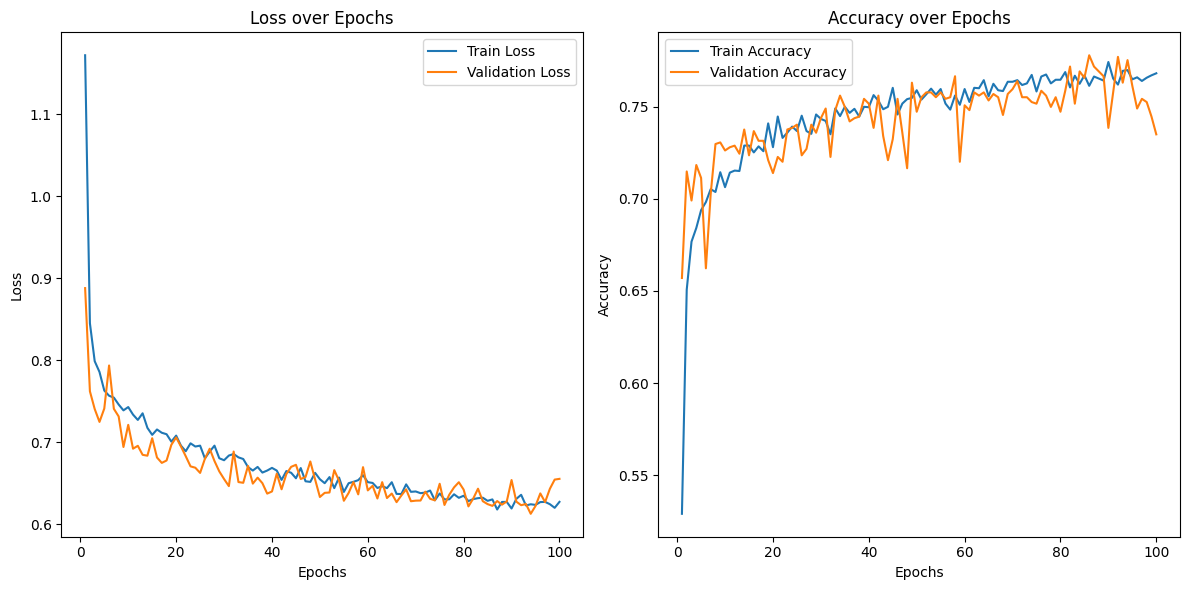

In [45]:

plt.figure(figsize=(12, 6))

epochs = len(train_loss)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 3.3 Evaluate model

In [46]:
# Configure paths and parameters
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
model_path = '/kaggle/working/best_unetmodel.keras'
classes = ['glioma','notumor',  'meningioma', 'pituitary']
target_size = (128, 128)
output_dir = '/kaggle/working/testing/predicted_masks'

# Call the function
masks_test, labels_test= generate_mask(test_dir, classes, target_size,model_path)

# Save masks by class
save_masks_by_class(masks_test, labels_test, classes, output_dir)


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 572ms/step
Class 'glioma': 300 masks
Class 'notumor': 405 masks
Class 'meningioma': 306 masks
Class 'pituitary': 300 masks
Masks have been saved to /kaggle/working/testing/predicted_masks.


In [47]:
# Evaluate model by test data
test_loss, test_accuracy = model.evaluate(masks_test, labels_test,batch_size=32)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6502 - loss: 0.7542
Test Loss: 0.6119540929794312, Test Accuracy: 0.7734553813934326


In [48]:
# Use the trained model to make predictions
y_pred = model.predict(masks_test)

# Get the predicted class labels (select the class with the highest probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display the predicted classes and the true labels
print(f'Predicted classes: {y_pred_classes[:10]}')
print(f'True classes: {labels_test[:10]}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step
Predicted classes: [2 2 0 0 2 2 0 2 2 0]
True classes: [0 0 0 0 0 0 0 0 0 0]


In [49]:
from sklearn.metrics import accuracy_score

if labels_test.ndim > 1:
    labels_test = np.argmax(labels_test, axis=1)

# Calculate accuracy for each class
unique_classes = np.unique(labels_test)
class_accuracies = []

for cls in unique_classes:
    # Get all true labels and predicted labels for class cls
    true_class = (labels_test == cls)
    pred_class = (y_pred_classes == cls)

    # Calculate the accuracy for this class
    accuracy = np.sum(true_class & pred_class) / np.sum(true_class)  # Accuracy for this class
    class_accuracies.append(accuracy)

# Calculate the sample weights for each class
class_counts = np.array([np.sum(labels_test == cls) for cls in unique_classes])
class_weights = class_counts / np.sum(class_counts)

# Calculate weighted accuracy
weighted_accuracy = np.sum(np.array(class_accuracies) * class_weights)

print(f"Weighted Accuracy: {weighted_accuracy}")


Weighted Accuracy: 0.7734553775743707


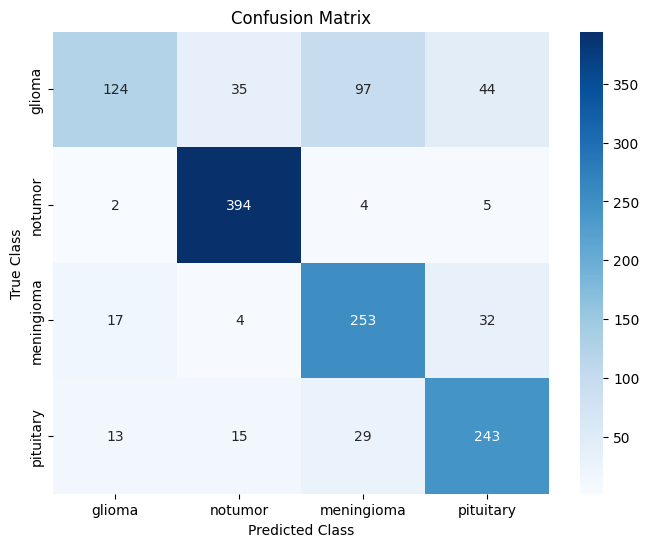

In [50]:
# Compute the confusion matrix
cm = confusion_matrix(labels_test, y_pred_classes)


 

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()